# Import Libraries

In [1]:
#for data preprocessing
import numpy as np
import pandas as pd


import seaborn as sns
import matplotlib.pyplot as plt

import os
from glob import glob
from tqdm import tqdm, tqdm_notebook

import gc

import warnings
warnings.filterwarnings("ignore")

# Load the Data

In [2]:
# Show the directory structure
root_dir = "C:\\Users\\raman\\BBC_project\\BBC News Summary\\News Articles"

# Show the folders inside the root
print(os.listdir(root_dir))

['business', 'entertainment', 'politics', 'sport', 'tech']


In [3]:
#List which has the unique category names
unique_category = os.listdir(root_dir)
#List to store the category names
news_category_list = []
#List to store the news articles
news_articles_list = []

#Iterate through unique category
for category in tqdm(unique_category,colour='yellow'):
    # Get the absolute path of that category directory
    abs_category_path = root_dir + "/" + category
    
    # Create a query to get the absolute path of all the .txt files
    query = abs_category_path + "/*.txt"
    
    # Get the list of absolute path of all the files
    file_paths = glob(query)
    
    # Iterate through all the .txt files path
    for file_path in file_paths:
        try:
            # Open the file
            f = open(file_path, 'r')
            # Read the file contents
            news_article = f.read()
            # Close the file
            f.close()
        except:
            # Open the file
            f = open(file_path, 'rb')
            # Read the file contents
            news_article = f.read()
            # Close the file
            f.close()
            
        # Append new articles and category to respective list
        news_articles_list.append(news_article)
        news_category_list.append(category)
        
# Print length of news articles and categories
print("Total Articles: ", len(news_articles_list))
print("Total Categories: ", len(news_category_list), end='\n\n')

# Print a sample article
print("Sample Article: ")
print(news_articles_list[0])



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:14<00:00,  2.89s/it]

Total Articles:  2225
Total Categories:  2225

Sample Article: 
Ad sales boost Time Warner profit

Quarterly profits at US media giant TimeWarner jumped 76% to $1.13bn (Â£600m) for the three months to December, from $639m year-earlier.

The firm, which is now one of the biggest investors in Google, benefited from sales of high-speed internet connections and higher advert sales. TimeWarner said fourth quarter sales rose 2% to $11.1bn from $10.9bn. Its profits were buoyed by one-off gains which offset a profit dip at Warner Bros, and less users for AOL.

Time Warner said on Friday that it now owns 8% of search-engine Google. But its own internet business, AOL, had has mixed fortunes. It lost 464,000 subscribers in the fourth quarter profits were lower than in the preceding three quarters. However, the company said AOL's underlying profit before exceptional items rose 8% on the back of stronger internet advertising revenues. It hopes to increase subscribers by offering the online service 

# Convert the raw data to dataframe

In [4]:
#Dictionary to create a new dataframe
df_dict = {'news':news_articles_list,'labels':news_category_list}

#convert to dataframe
df = pd.DataFrame(df_dict)

#show dataframe
df.head()

,news,labels
0,Ad sales boost Time Warner profit\n\nQuarterly...,business
1,Dollar gains on Greenspan speech\n\nThe dollar...,business
2,Yukos unit buyer faces loan claim\n\nThe owner...,business
3,High fuel prices hit BA's profits\n\nBritish A...,business
4,Pernod takeover talk lifts Domecq\n\nShares in...,business


In [5]:
#delete unwanted  variable to save space
del news_articles_list,news_category_list,df_dict
#clear the cache
gc.collect()

0

# Remove the '\n' from news articles

In [6]:
#Function to removing the '/n' from the news articles
def remove_ns(text):
    return text.replace('\n',' ')

#to show the progress of apply
tqdm_notebook().pandas()

#Apply this to the dataframe
df['news'] = df['news'].progress_apply(remove_ns)

#show the dataframe
df.head()

0it [00:00, ?it/s]

  0%|          | 0/2225 [00:00<?, ?it/s]

,news,labels
0,Ad sales boost Time Warner profit Quarterly p...,business
1,Dollar gains on Greenspan speech The dollar h...,business
2,Yukos unit buyer faces loan claim The owners ...,business
3,High fuel prices hit BA's profits British Air...,business
4,Pernod takeover talk lifts Domecq Shares in U...,business


# Exploratory Data Analysis

# Looking at the distribution of labels

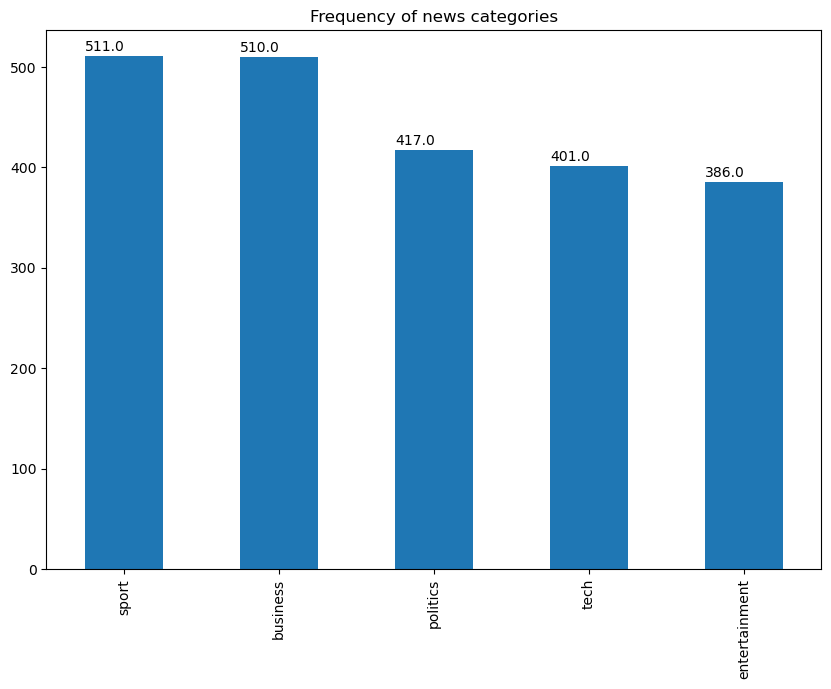

In [7]:
ax = df['labels'].value_counts().plot(kind='bar',figsize=(10,7))
for p in ax.patches:
    ax.annotate("{:.1f}".format(p.get_height()), (p.get_x(), p.get_height()+5))
plt.title("Frequency of news categories")
plt.show()

# Looking at the distribution of length of news articles across categories

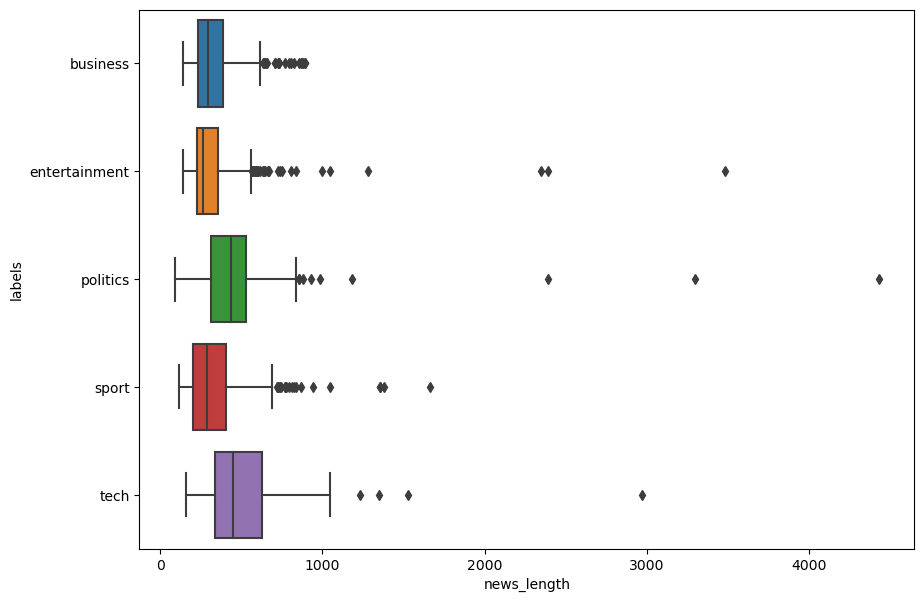

In [8]:
#Create a column which stores the length of the news articles
df['news_length'] = df['news'].str.split().apply(len)

#create a subplot
fig,ax = plt.subplots(figsize=(10,7))

# Plot a boxplot showing the distribution of the length of news articles across categories
sns.boxplot(x='news_length',y='labels',data=df,ax=ax)

#show the plot
plt.show()

In [9]:
#Print the median values of the news length
df.groupby('labels').median().T

labels,business,entertainment,politics,sport,tech
news_length,297.0,262.5,439.0,288.0,447.0


In [10]:
#print the mean values of the news length
df.groupby('labels').mean().T

labels,business,entertainment,politics,sport,tech
news_length,328.880392,330.621762,453.973621,329.262231,502.695761


In [11]:
# Get the indexes of such entries (will be used later to demonstrate tokenization)
df[df['news_length']<512].index

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            2203, 2204, 2208, 2210, 2213, 2215, 2216, 2220, 2221, 2223],
           dtype='int64', length=1804)

In [12]:
# Get the number of articles whose length is greater than DistilBERT context size
print("No. of articles with greater length than DistilBERT max context size: ", len(df[df['news_length']>=512]))

No. of articles with greater length than DistilBERT max context size:  421


We will have to truncate these articles such that their length becomes less than the DistilBERT's max context size.
This step can have a negative impact on the model we build, as there is loss of information.

# Encoding the categorical new labels to numerical

In [13]:
from sklearn.preprocessing import LabelEncoder

In [14]:
#Initialize the label encoder object
label_encoder = LabelEncoder()

#Fit the label Encoder
label_encoder.fit(df['labels'])

#Encode the categorical data to numerical
df['labels'] = label_encoder.transform(df['labels'])

#show the transformed labels
df.head()

,news,labels,news_length
0,Ad sales boost Time Warner profit Quarterly p...,0,421
1,Dollar gains on Greenspan speech The dollar h...,0,384
2,Yukos unit buyer faces loan claim The owners ...,0,264
3,High fuel prices hit BA's profits British Air...,0,406
4,Pernod takeover talk lifts Domecq Shares in U...,0,265


In [15]:
# Print the categories and their respective labels
print(f"Unique Categories:{unique_category}")
print(f"Trans Categories :{label_encoder.transform(unique_category)}")

Unique Categories:['business', 'entertainment', 'politics', 'sport', 'tech']
Trans Categories :[0 1 2 3 4]


# Convert DataFrame to HuggingFace Dataset

In [16]:
from datasets import Dataset

In [17]:
# Delete the news length column
del df['news_length']

# Print the dataframe
df.head()

,news,labels
0,Ad sales boost Time Warner profit Quarterly p...,0
1,Dollar gains on Greenspan speech The dollar h...,0
2,Yukos unit buyer faces loan claim The owners ...,0
3,High fuel prices hit BA's profits British Air...,0
4,Pernod takeover talk lifts Domecq Shares in U...,0


In [18]:
#convert to hugging face dataset
hf_data = Dataset.from_pandas(df)

#show dataset
hf_data

Dataset({
    features: ['news', 'labels'],
    num_rows: 2225
})

# Tokenizing the articles

In [19]:
import torch
from transformers  import AutoTokenizer

In [20]:
# Model checkpoint to use
model_ckpt = "distilbert-base-uncased"

# Set a device to load the tokenizer to
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize a tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

# Tokenize a single article

In [21]:
#tokenize a single text
tokenized_record = tokenizer(hf_data['news'][0])

#print the tokenized record
tokenized_record

Token indices sequence length is longer than the specified maximum sequence length for this model (573 > 512). Running this sequence through the model will result in indexing errors


{'input_ids': [101, 4748, 4341, 12992, 2051, 6654, 5618, 12174, 11372, 2012, 2149, 2865, 5016, 2051, 9028, 3678, 5598, 6146, 1003, 2000, 1002, 1015, 1012, 2410, 24700, 1006, 1037, 29646, 16086, 2692, 2213, 1007, 2005, 1996, 2093, 2706, 2000, 2285, 1010, 2013, 1002, 6191, 2683, 2213, 2095, 1011, 3041, 1012, 1996, 3813, 1010, 2029, 2003, 2085, 2028, 1997, 1996, 5221, 9387, 1999, 8224, 1010, 19727, 2013, 4341, 1997, 2152, 1011, 3177, 4274, 7264, 1998, 3020, 4748, 16874, 4341, 1012, 2051, 9028, 3678, 2056, 2959, 4284, 4341, 3123, 1016, 1003, 2000, 1002, 2340, 1012, 26314, 2078, 2013, 1002, 2184, 1012, 1023, 24700, 1012, 2049, 11372, 2020, 20934, 6977, 2098, 2011, 2028, 1011, 2125, 12154, 2029, 16396, 1037, 5618, 16510, 2012, 6654, 10243, 1010, 1998, 2625, 5198, 2005, 20118, 2140, 1012, 2051, 6654, 2056, 2006, 5958, 2008, 2009, 2085, 8617, 1022, 1003, 1997, 3945, 1011, 3194, 8224, 1012, 2021, 2049, 2219, 4274, 2449, 1010, 20118, 2140, 1010, 2018, 2038, 3816, 18023, 1012, 2009, 2439, 4805, 2

The tokenizer has returned a dictionary with 2 keys: input_ids and attention_mask.
The input_ids are the actual tokenized text, where each word is mapped to an integer.
The attention_mask on the other hand is a binary tensor that tells the model which input_id to attend and which to skip. 1 means that its corresponding input_id is a word, and 0 means its corresponding input_id is a padded value.
This helps the model to ignore/mask certain parts of the inputs during training and inference which saves time and resources.

# Comparing the length of article before and after tokenization

In [22]:
print('Length before tokenization:',len(hf_data['news'][0].split()))
print('Length after tokenization:',len(tokenized_record.input_ids))

Length before tokenization: 421
Length after tokenization: 573


We can see that the lenth of the articles has increased after tokenization, this is because of the tokenization nature DistilBERT's tokenizer, let's compare the raw text and the tokenized text to understand in detail.

In [23]:
# Convert the input_ids to tokens/words
tokenized_tokens = tokenizer.convert_ids_to_tokens(tokenized_record.input_ids)

# Convert the list of tokenized words to a single text
tokenized_text = " ".join(tokenized_tokens)

# Print the untokenized raw text
print("Raw Article:")
print(hf_data['news'][0], end='\n\n')

# Print the input_ids
print("Raw Text to Input IDs:")
print(tokenized_record.input_ids, end="\n\n")

# Print the tokenized tokens
print("Input IDs to Words:")
print(tokenized_text)

Raw Article:
Ad sales boost Time Warner profit  Quarterly profits at US media giant TimeWarner jumped 76% to $1.13bn (Â£600m) for the three months to December, from $639m year-earlier.  The firm, which is now one of the biggest investors in Google, benefited from sales of high-speed internet connections and higher advert sales. TimeWarner said fourth quarter sales rose 2% to $11.1bn from $10.9bn. Its profits were buoyed by one-off gains which offset a profit dip at Warner Bros, and less users for AOL.  Time Warner said on Friday that it now owns 8% of search-engine Google. But its own internet business, AOL, had has mixed fortunes. It lost 464,000 subscribers in the fourth quarter profits were lower than in the preceding three quarters. However, the company said AOL's underlying profit before exceptional items rose 8% on the back of stronger internet advertising revenues. It hopes to increase subscribers by offering the online service free to TimeWarner internet customers and will try 

We can observe a few things here, firstly we can see that [CLS] and [SEP] token is added in the start and end respectively, which indicates the start and the end of the sequence.
Secondly, all the tokens has been converted to lowercase.
Finally, we can see that in many places the tokenizer has added the ## signs as prefix in many places. It means that preceeding string is not whitespace, any token with ## prefix needs to be merged with its previous token.
Additional Notes: This type of tokenization is called as Subword Tokenization. To know more about it please referer to the Subword Tokenization space in this huggingface documentation - https://huggingface.co/docs/transformers/tokenizer_summary

We know that the DistilBERT's max context size is 512 and we have a lot of articles with length more than that as we saw in the box plot.
In order to handle this issue we need to trucate the articles we discussed, and to implement it the tokenizer takes an argument called truncation which takes a boolean value and truncates the text according to the model's max context size.
We also saw that there are a lot of articles with length less than that of the DistilBERT's max context size.
In order to handle this issue we need to use the padding concept and to implement it the tokenizer takes an additional argument called padding which also takes a boolean value and applies padding according to the model's max context size

# Tokenize single article with truncation and padding

In [24]:
#tokenize a single text
tokenized_record_wtp = tokenizer(hf_data['news'][0],truncation=True,padding=True)
#print the tokenized record
tokenized_record_wtp

{'input_ids': [101, 4748, 4341, 12992, 2051, 6654, 5618, 12174, 11372, 2012, 2149, 2865, 5016, 2051, 9028, 3678, 5598, 6146, 1003, 2000, 1002, 1015, 1012, 2410, 24700, 1006, 1037, 29646, 16086, 2692, 2213, 1007, 2005, 1996, 2093, 2706, 2000, 2285, 1010, 2013, 1002, 6191, 2683, 2213, 2095, 1011, 3041, 1012, 1996, 3813, 1010, 2029, 2003, 2085, 2028, 1997, 1996, 5221, 9387, 1999, 8224, 1010, 19727, 2013, 4341, 1997, 2152, 1011, 3177, 4274, 7264, 1998, 3020, 4748, 16874, 4341, 1012, 2051, 9028, 3678, 2056, 2959, 4284, 4341, 3123, 1016, 1003, 2000, 1002, 2340, 1012, 26314, 2078, 2013, 1002, 2184, 1012, 1023, 24700, 1012, 2049, 11372, 2020, 20934, 6977, 2098, 2011, 2028, 1011, 2125, 12154, 2029, 16396, 1037, 5618, 16510, 2012, 6654, 10243, 1010, 1998, 2625, 5198, 2005, 20118, 2140, 1012, 2051, 6654, 2056, 2006, 5958, 2008, 2009, 2085, 8617, 1022, 1003, 1997, 3945, 1011, 3194, 8224, 1012, 2021, 2049, 2219, 4274, 2449, 1010, 20118, 2140, 1010, 2018, 2038, 3816, 18023, 1012, 2009, 2439, 4805, 2

# Compare the length of articles before and after tokenization with truncation and padding

In [25]:
print("Length before tokenization: ", len(hf_data['news'][0].split()))
print("Length after tokenization: ", len(tokenized_record_wtp.input_ids))

Length before tokenization:  421
Length after tokenization:  512


Length before tokenization:  421

Length after tokenization:  512

We can see that the length of the text has been truncated from 573 to 512
This step results in information loss as many tokens are simply dropped

# Check how the text is tokenized with truncation and padding

In [26]:
# Convert the input_ids to tokens/words
tokenized_tokens_wtp = tokenizer.convert_ids_to_tokens(tokenized_record_wtp.input_ids)

# Convert the list of tokenized words to a single text
tokenized_text_wtp = " ".join(tokenized_tokens_wtp)

# Print the untokenized raw text
print("Raw Article:")
print(hf_data['news'][0], end='\n\n')

# Print the input_ids
print("Raw Text to Input IDs:")
print(tokenized_record_wtp.input_ids, end="\n\n")

# Print the tokenized tokens
print("Input IDs to Words:")
print(tokenized_text_wtp)

Raw Article:
Ad sales boost Time Warner profit  Quarterly profits at US media giant TimeWarner jumped 76% to $1.13bn (Â£600m) for the three months to December, from $639m year-earlier.  The firm, which is now one of the biggest investors in Google, benefited from sales of high-speed internet connections and higher advert sales. TimeWarner said fourth quarter sales rose 2% to $11.1bn from $10.9bn. Its profits were buoyed by one-off gains which offset a profit dip at Warner Bros, and less users for AOL.  Time Warner said on Friday that it now owns 8% of search-engine Google. But its own internet business, AOL, had has mixed fortunes. It lost 464,000 subscribers in the fourth quarter profits were lower than in the preceding three quarters. However, the company said AOL's underlying profit before exceptional items rose 8% on the back of stronger internet advertising revenues. It hopes to increase subscribers by offering the online service free to TimeWarner internet customers and will try 

# Tokenize the whole article dataset with truncation and padding

# Split data into train set and split set

In [27]:
#split the data into train set and test set
hf_data_split = hf_data.train_test_split(test_size=0.2)

#show the splitted dataset
hf_data_split

DatasetDict({
    train: Dataset({
        features: ['news', 'labels'],
        num_rows: 1780
    })
    test: Dataset({
        features: ['news', 'labels'],
        num_rows: 445
    })
})

In [28]:
# Delete hf_data as it wil not be used
del hf_data

# Clear cache
gc.collect()

96

# Tokenize the whole article dataset

In [29]:
#A function which tokenizes the texts of a whole set(train/test)
def tokenize(batch):
    return tokenizer(batch['news'],truncation=True,padding=True)

In [30]:
#Applying the tokenized function to the whole dataset
hf_data_split_tokenized = hf_data_split.map(tokenize,batched=True,batch_size=None)

#showing the tokenized dataset
hf_data_split_tokenized['train']

Map:   0%|          | 0/1780 [00:00<?, ? examples/s]

Map:   0%|          | 0/445 [00:00<?, ? examples/s]

Dataset({
    features: ['news', 'labels', 'input_ids', 'attention_mask'],
    num_rows: 1780
})

In [31]:
# Showing the tokenized test dataset
hf_data_split_tokenized['test']

Dataset({
    features: ['news', 'labels', 'input_ids', 'attention_mask'],
    num_rows: 445
})

We can tokenize the whole dataset using the .map() function, where the function will be applied to both the Dataset inside the DataDict and by setting batch=True it will tokenize the data in batches, but as we have set batch_size=None the tokenizer will tokenize the full dataset as a single batch.

In [32]:
# Delete hf_data_split
del hf_data_split

# Clear the cache
gc.collect()

62

In [33]:
from transformers import AutoModel

In [34]:
#Load the pre trained model to our available device
model = AutoModel.from_pretrained(model_ckpt).to(device)

# Inspecting the output of model with single input

In [35]:
# Any random text
text = "This is a random text"

# Tokenize the text
inputs = tokenizer(text, return_tensors='pt')

# Print the tokenized 
print("Tokenized Input:")
print(inputs, end="\n\n")

# Print the tokenized text's input_ids shape
print(inputs['input_ids'].shape)

Tokenized Input:
{'input_ids': tensor([[ 101, 2023, 2003, 1037, 6721, 3793,  102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1]])}

torch.Size([1, 7])


We have given an parameter return_tensors='pt' which returns the tensor in pytorch format.
We can see that the tokenizer tokenizes and returns data with shape [batch_size, sequence_length]

In [36]:
# Add the inputs to our working device where our loaded model reisdes
inputs.to(device)
# Disable automatic calculation of gradients
with torch.no_grad():
    # Give the input_ids and attention mask to the model
    outputs = model(**inputs)
# Check the output
outputs

BaseModelOutput(last_hidden_state=tensor([[[-0.1903, -0.2716, -0.0031,  ..., -0.0990,  0.1529,  0.5457],
         [-0.3594, -0.4633, -0.2592,  ..., -0.2156,  0.5455,  0.5042],
         [-0.3533, -0.3095, -0.0491,  ..., -0.0680,  0.0387,  1.0844],
         ...,
         [ 0.2143, -0.6154,  0.0154,  ..., -0.3222, -0.1448,  0.1043],
         [-0.0927, -0.4738,  0.0066,  ..., -0.0058, -0.0991,  0.2114],
         [ 1.0047, -0.0394, -0.5573,  ...,  0.1634, -0.7061, -0.1302]]]), hidden_states=None, attentions=None)

We can notice that it has returned an output of type BaseModelOutput, where the hidden states is stored as a tensor in last_hidden_state inside it.

In [37]:
# Check the sie of the hidden state
outputs.last_hidden_state.size()

torch.Size([1, 7, 768])

Its has created a 768 dimensional vector representation for each of the tokens

In [38]:
# This is the representation for the [CLS] token
outputs.last_hidden_state[:,0].size()

torch.Size([1, 768])

Let's only visualize the [CLS] token's hidden states given by the model

# Feeding the model with the whole dataset to get hidden states of [CLS] token

In [39]:
# Function to create hidden states for whole set(train/test)
def extract_hidden_states(batch):
    # Load the values of the batch data to the device where model resides
    inputs = {k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}
    
    # Disable the automatic calculation of gradients
    with torch.no_grad():
        # Feed the input to the model
        last_hidden_states = model(**inputs).last_hidden_state
        
    # Return the column consisting of hidden states of data
    return {'hidden_states': last_hidden_states[:,0].cpu().numpy()}

In the first line of the function, we are loading the values which the model takes as input(input_ids & attention_mask) to the device where the model resides.
Here in the last line we have loaded the last hidden states in the cpu as a numpy array.
Before we extract the hidden features, we need to convert the inputs tensors to pytorch format

# Convert dataset's tensors to pytorch tensor format

In [40]:
# We can easily do it using the .set_format() method
hf_data_split_tokenized.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])

# Extract the hidden states for the [CLS] token

In [41]:
# Extract the hidden states of the whole dataset(train & test)
hf_hidden = hf_data_split_tokenized.map(extract_hidden_states, batched=True, batch_size=100)

# Show the hidden dataset
hf_hidden

Map:   0%|          | 0/1780 [00:00<?, ? examples/s]

Map:   0%|          | 0/445 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['news', 'labels', 'input_ids', 'attention_mask', 'hidden_states'],
        num_rows: 1780
    })
    test: Dataset({
        features: ['news', 'labels', 'input_ids', 'attention_mask', 'hidden_states'],
        num_rows: 445
    })
})

# Performing Dimension Reduction for hidden states to visualize

In [42]:
from sklearn.manifold import TSNE

In [43]:
# Get the hidden space vector which has to be reduced
X = hf_hidden['train']['hidden_states']

# Get its corresponding labels
Y = hf_hidden['train']['labels']

In [44]:
# Initialize the TSNE model
tsne_model = TSNE(n_components=2)

# Perform dimension reduction on the hidden space vector
X_red = tsne_model.fit_transform(X)

# Print the shape of reduced vector
X_red.shape

(1780, 2)

We have successfully reduced hidden states of [CLS] token for each of the 1780 articles in the training set

# Convert to dataframe to visualize

In [45]:
# Dictionary with hidden states and labels to convert to dataframe
df_red_dict = {"X":X_red[:,0],"Y":X_red[:,1], "label":Y}

# Convert to dataframe
df_red = pd.DataFrame(df_red_dict)

# Show dataframe
df_red.head()

,X,Y,label
0,-33.583405,21.956972,0
1,0.488302,48.305130,0
2,-24.034260,46.674141,0
3,29.078957,-54.973038,3
4,6.459774,-10.463651,1


# Visualizing the hidden states of the DistilBERT model reduced by T-SNE

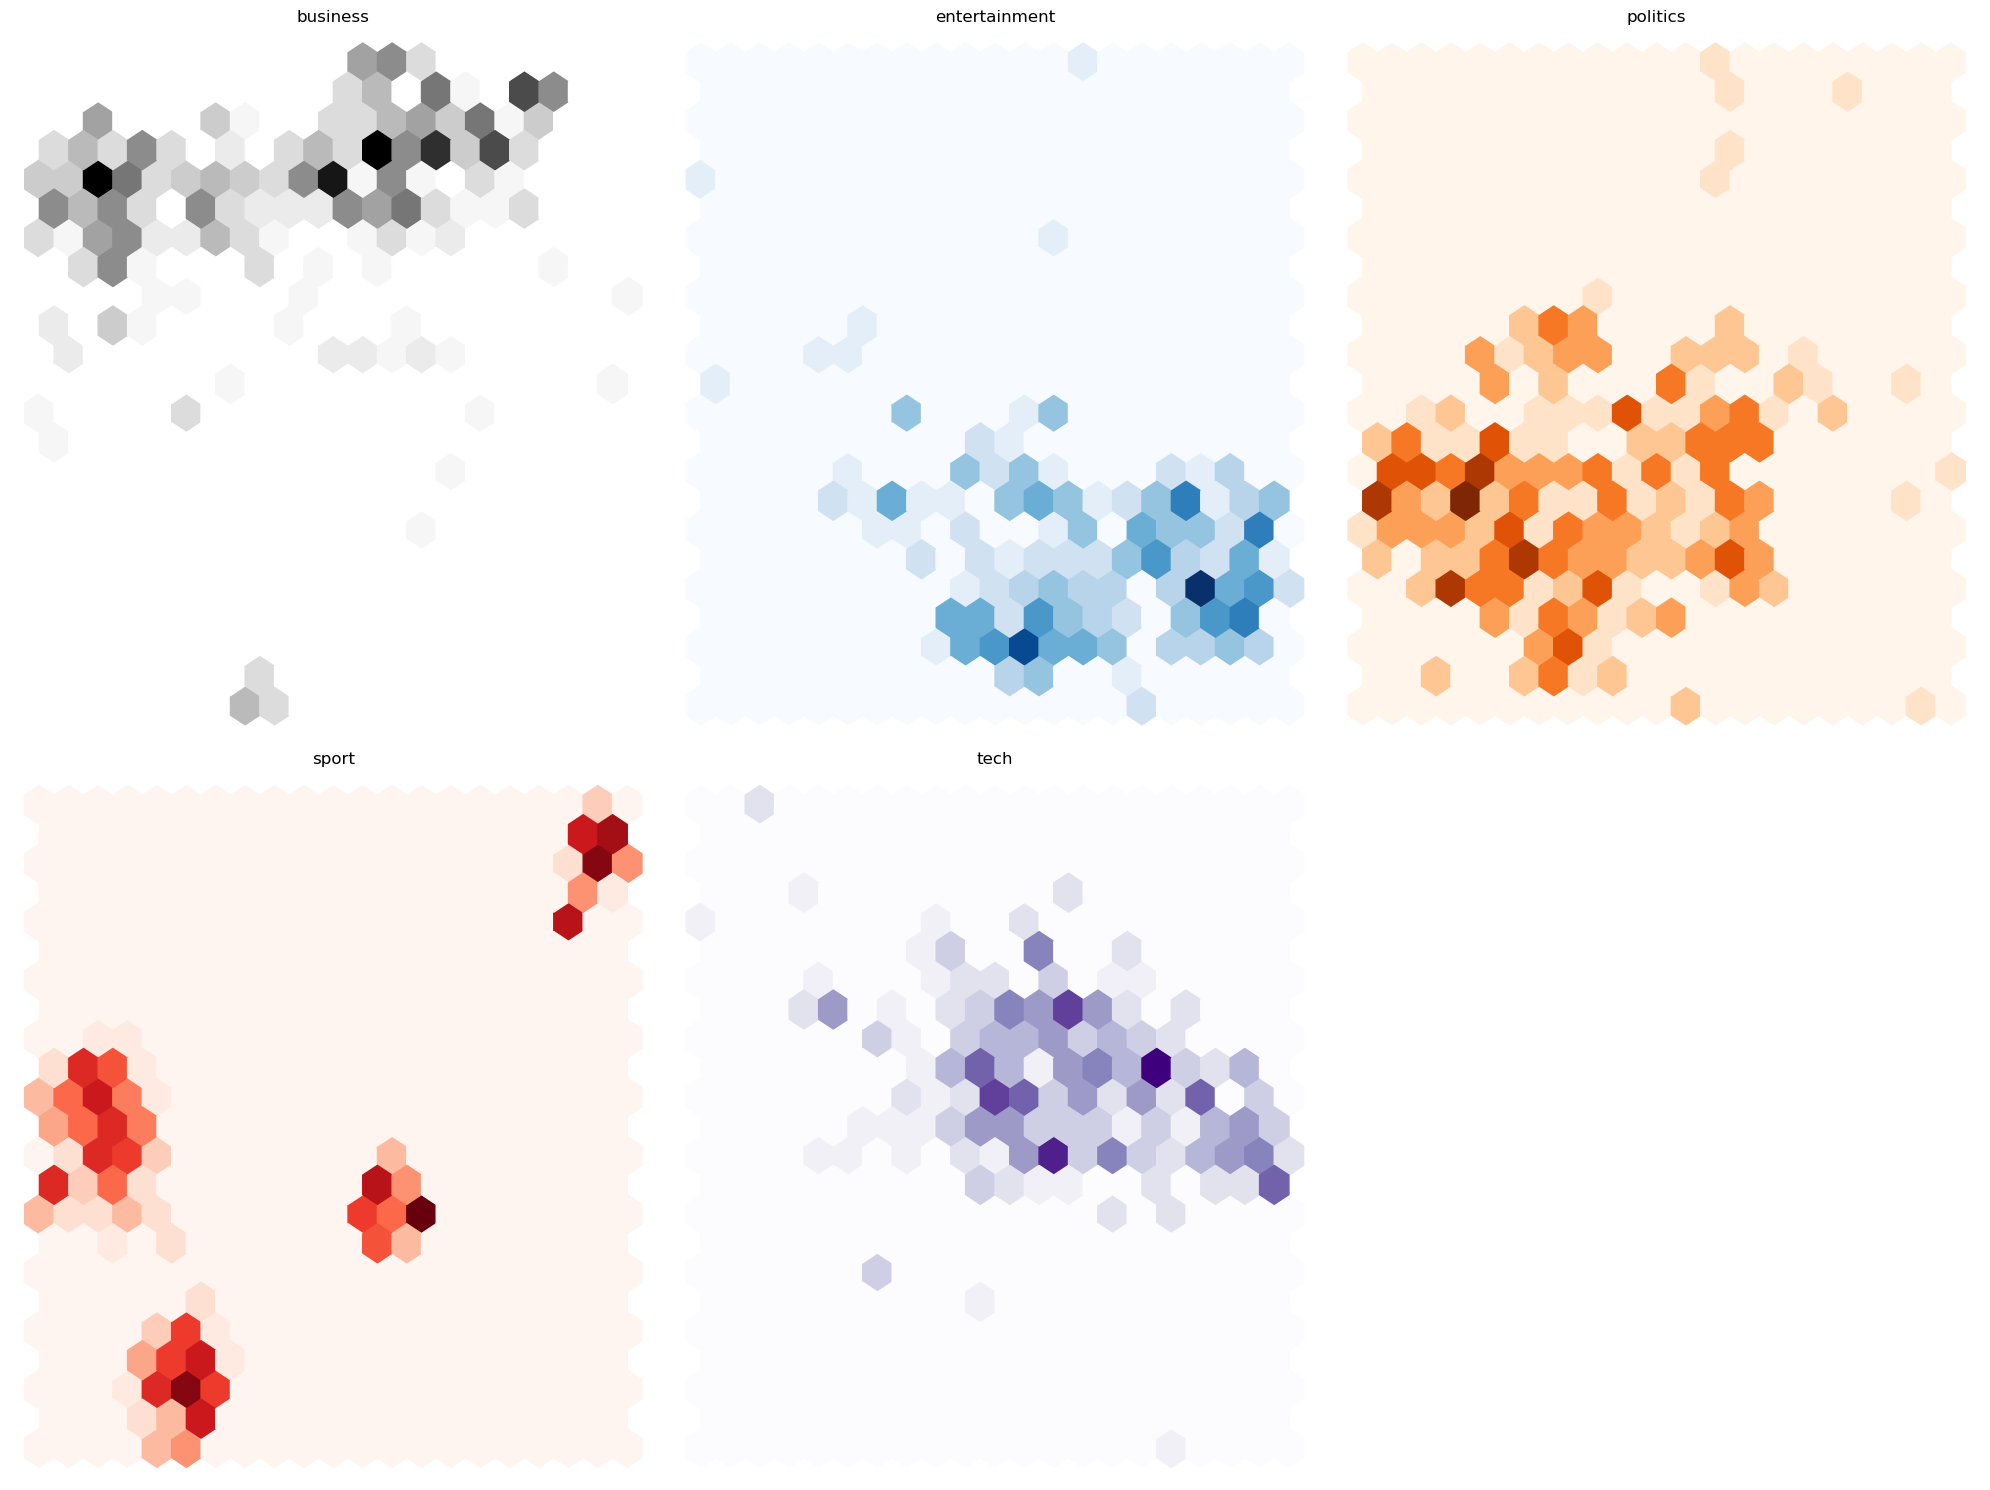

In [46]:
# Create subplots
fig, ax = plt.subplots(2,3, figsize=(20,15))

# Palettes to use to plot
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples"]

# Encoded labels
encoded_labels = label_encoder.transform(unique_category)

# Iterate through each category and plot its data
for index, (label, cmap) in enumerate(zip(encoded_labels, cmaps)):
    # Get the hidden features where of the iteration label
    df_red_sub = df_red.query(f"label=={label}")
    
    # Plot the hexbin plot
    ax.ravel()[index].hexbin(df_red_sub['X'],df_red_sub['Y'], cmap=cmap, gridsize=20)
    
    # Get the name of category
    category = label_encoder.inverse_transform([label])[0]
    
    # Plot the news category as title
    ax.ravel()[index].set_title(category)
    
    # Set the axis off
    ax.ravel()[index].set_axis_off()
    
# Set the axis of last plot off as we have 2 rows and 2 columns in subplots
ax.ravel()[5].set_axis_off()
    
    
plt.tight_layout()
plt.show()

Observations:¶
We can clearly see that the sport category and entertainment category has a huge overlap, this was expected as in real world sports is a billion dollar market when it comes to entertainment and this thing is highlighted in the articles due to choice of words.
We can also see a sligh overlap in the politics and entertainment category. We know politics also is a part of entertainment for some adults and middle-age individuals. It may also mean that politics articles may have words which are used for entertainment articles.
We could also notice that tech and business also has some overlap. This could be because of the sever relation between innovation and money. We know that influence in tech also influences the business, and visa-versa. It may also mean that tech articles and business articles might have some similar common words.
Note: These are just assumptions based on the results. The above graphs might not be reproducable. Assumptions like these might require to go through Hypothesis Testing to conclude whether there is really a relation or its due to random chance. However, as this is out of scope for this case study, let's proceed further with fine-tuning our model

# Fine-Tuning DistilBERT for our casestudy

# Clear the unwanted storage stored in device to make space for training

In [47]:
# Delete unwanted variables to save space
del hf_hidden, X, Y, X_red, df_red, df_red_dict

# Clear cache
gc.collect()

5010

In [48]:
# Clear GPU cache
torch.cuda.empty_cache()

# Loading the model

In [49]:
from transformers import AutoModelForSequenceClassification

In [50]:
# Set the number of labels we want to predict
num_labels = 5

# Load and configure the pre-trained model
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels).to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'classifier.bias', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).

- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classifier.weight', 'classifier.bias']

You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference

# Defining function to calculate metrics

In [51]:
from sklearn.metrics import accuracy_score, f1_score, ConfusionMatrixDisplay, confusion_matrix, classification_report

In [52]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [53]:
def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(12, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

# Configure the model's parameters

In [54]:
from transformers import TrainingArguments

In [ ]:
# Set the number of epochs and batch size and learning rate and model name
epochs = 2
batch_size = 1
learning_rate = 2e-5
model_name = f"{model_ckpt}-bbc-finetuned"

# Create a training argument object
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=epochs,
                                  learning_rate=learning_rate,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  evaluation_strategy='epoch',
                                  gradient_accumulation_steps=16,
                                  disable_tqdm=False,
                                  push_to_hub=False)

# Initialize the model

In [64]:
from transformers import Trainer

In [ ]:
trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=hf_data_split_tokenized['train'],
                  eval_dataset=hf_data_split_tokenized['test'],
                  tokenizer=tokenizer)

# Train the model

In [ ]:
torch.cuda.empty_cache()

In [ ]:
trainer.train()

# Evaluate the model

In [ ]:
# Make predictions on the test set
predictions = trainer.predict(hf_data_split_tokenized['test'])

# Get the prediction metrics
predictions.metrics

In [ ]:
# Get the predicted labels from the predictions
y_preds = np.argmax(predictions.predictions, axis=1)

# Get the real labels of test set from the dataset
y_valid = hf_data_split_tokenized['test']['labels']

In [ ]:
# Plot the confusion matrix
plot_confusion_matrix(y_preds, y_valid, labels=unique_category)

In [ ]:
print(classification_report(y_true=y_valid, y_pred=y_preds))

The confusion matrix also looks really great! Our DistilBERT model has excellently classified the new articles with some very minute misclassifications